#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt**
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt

In [3]:
class NaiveBayes:
    def __init__(self, discretization= 4):
        self.priors = {}
        self.likelihoods = {}
        self.discretization = discretization
        self.bins = []

    def build_classifier(self, train_features, train_classes):
        # setting priors, its P(y)
        discret_train_features = self._prepare_bins(train_features)
        for y in train_classes:
            self.priors[y] = sum(train_classes == y)/len(train_classes)

        # setting likelihoods, its P(xi|y)
        for column in range(len(discret_train_features[0])):
            for input_value in range(self.discretization):
                for output_value in self.priors:
                    feature_cond = discret_train_features[:, column] == input_value
                    class_cond = train_classes == output_value
                    count_feature_class = np.sum(feature_cond & class_cond) + 1

                    count_class = self.priors[output_value] * len(train_classes)
                    self.likelihoods[(column, input_value, output_value)] = count_feature_class / count_class


    def data_discretization(self, data):
        discret_data = np.digitize(data, self.bins[:-1], right=True)
        return discret_data

    def _prepare_bins(self, data):
        _, bins = np.histogram(data, bins=self.discretization-1)
        self.bins = bins
        return self.data_discretization(data)

    def predict(self, sample):
        likelyhoods = {}
        discret_sample = self.data_discretization(sample)
        for output_value in self.priors:
            likelyhood = self.priors[output_value]

            for column, input_value in enumerate(discret_sample):
                if (column, input_value, output_value) in self.likelihoods:
                    likelyhood *= self.likelihoods[(column, input_value, output_value)]

            likelyhoods[output_value] = likelyhood

        return max(likelyhoods, key=likelyhoods.get)


class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}
        self.means_and_stds = {}

    def build_classifier(self, train_features, train_classes):
        # setting priors, its P(y)
        for y in train_classes:
            self.priors[y] = sum(train_classes == y)/len(train_classes)

        for column in range(len(train_features[0])):
            for output_value in self.priors:
                selected_values = train_features[:,column][train_classes == output_value]
                mean = np.mean(selected_values)
                std = np.std(selected_values)

                self.means_and_stds[(output_value, column)] = [mean, std]


    def normal_dist(self, x, mean, std):
        numerator = math.exp(-((x - mean)**2) / (2 * std**2))
        denominator = std * math.sqrt(2 * math.pi)
        pdf_value = numerator / denominator
        return pdf_value

    def predict(self, sample):
        likelyhoods = {}

        for output_value in self.priors:
            likelyhood = math.log(self.priors[output_value])

            for column, input_value in enumerate(sample):
                mean = self.means_and_stds[(output_value, column)][0]
                std = self.means_and_stds[(output_value, column)][1]
                likelyhood += math.log(self.normal_dist(input_value, mean, std))

            likelyhoods[output_value] = likelyhood

        return max(likelyhoods, key=likelyhoods.get)


# BASIC TEST

| bayes | gaussian | real value |
|   1   |    1	   |      1     |
|   2   |    2	   |      2     |
|   2   |    2	   |      2     |
|   1   |    1	   |      1     |
|   0   |    0	   |      0     |
#   1   |    2	   |      2     |
|   1   |    1	   |      1     |
|   0   |    0	   |      0     |
|   0   |    0	   |      0     |
|   1   |    1	   |      1     |
#   1   |    2	   |      2     |
|   0   |    0	   |      0     |
|   1   |    1	   |      1     |
|   2   |    2	   |      2     |
|   2   |    2	   |      2     |


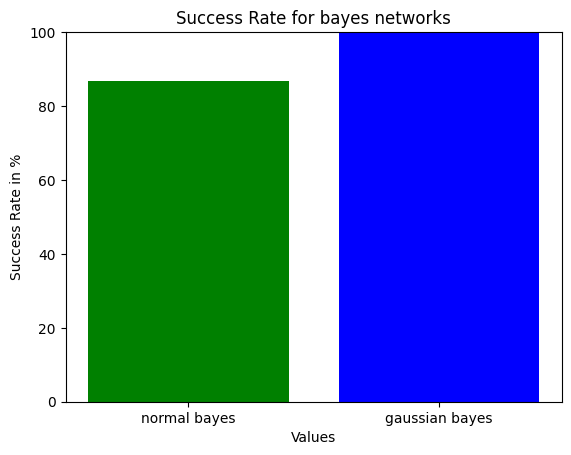

In [4]:
iris = load_iris()
x = iris.data
y = iris.target
bayes = NaiveBayes(4)
bayes_gaussian = GaussianNaiveBayes()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
bayes.build_classifier(x_train,y_train)
bayes_gaussian.build_classifier(x_train,y_train)
bayes_res = 0
bayes_gaussian_res = 0
print("| bayes | gaussian | real value |")
for inp, out in zip(x_test, y_test):
    bayess_guess = bayes.predict(inp)
    gaussian_guess = bayes_gaussian.predict(inp)
    bayes_res += 1 if bayess_guess == out else 0
    bayes_gaussian_res += 1 if gaussian_guess == out else 0
    if bayess_guess != out or gaussian_guess != out:
        print("#", end='')
    else:
        print("|", end='')
    print(f"   {bayess_guess}   |    {gaussian_guess}\t   |      {out}     |")


values = ['normal bayes', 'gaussian bayes']
success_rate = [bayes_res/len(y_test)*100, bayes_gaussian_res/len(y_test)*100]


plt.bar(values, success_rate, color=['green', 'blue'])
plt.xlabel('Values')
plt.ylabel('Success Rate in %')
plt.title('Success Rate for bayes networks')
plt.ylim(0, 100)
plt.show()

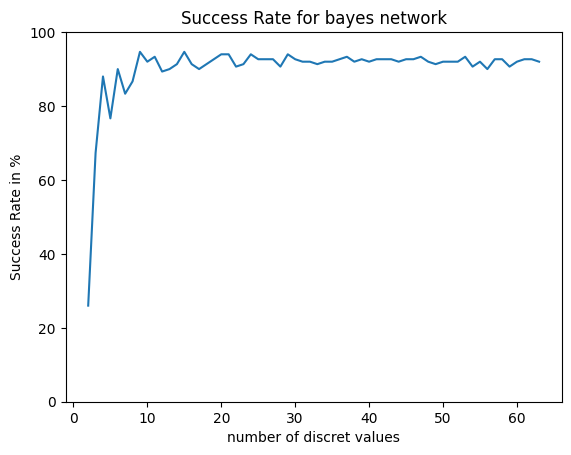

In [24]:
iris = load_iris()

x = iris.data
y = iris.target

bayes_rates={}

for discret in range(2,64):
    bayes = NaiveBayes(discret)
    for seed in range(10):
        res = 0
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=seed)
        bayes.build_classifier(x_train, y_train)

        for inp, out in zip(x_test, y_test):
            res += 1 if bayes.predict(inp) == out else 0
        bayes_rates[discret] = bayes_rates.setdefault(discret, [])
        bayes_rates[discret].append(res/len(y_test))
    bayes_rates[discret] = np.mean(bayes_rates[discret])*100

values = list(range(2,64))
success_rate = bayes_rates.values()


plt.plot(values, success_rate)
plt.xlabel('number of discret values')
plt.ylabel('Success Rate in %')
plt.title('Success Rate for bayes network(mean from 10 seeds)')
plt.ylim(0, 100)
plt.show()

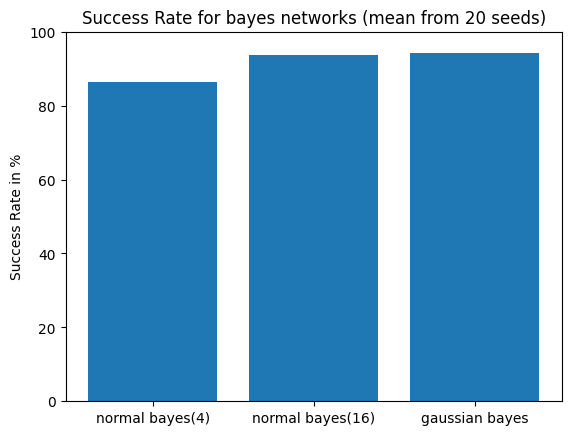

In [26]:
iris = load_iris()
x = iris.data
y = iris.target

bayes4 = NaiveBayes(4)
bayes16 = NaiveBayes(16)
bayes_gaussian = GaussianNaiveBayes()

bayes_rates = {'gaussian': [], 'regular': [], 'regular16': []}

for seed in range(20):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=seed)

    bayes_gaussian.build_classifier(x_train, y_train)
    bayes4.build_classifier(x_train, y_train)
    bayes16.build_classifier(x_train, y_train)

    bayes4_res = sum(1 for inp, out in zip(x_test, y_test) if bayes4.predict(inp) == out)
    bayes16_res = sum(1 for inp, out in zip(x_test, y_test) if bayes16.predict(inp) == out)
    bayes_gaussian_res = sum(1 for inp, out in zip(x_test, y_test) if bayes_gaussian.predict(inp) == out)

    bayes_rates['gaussian'].append(bayes_gaussian_res / len(y_test))
    bayes_rates['regular'].append(bayes4_res / len(y_test))
    bayes_rates['regular16'].append(bayes16_res / len(y_test))


bayes_rates['gaussian'] = np.mean(bayes_rates['gaussian']) * 100
bayes_rates['regular'] = np.mean(bayes_rates['regular']) * 100
bayes_rates['regular16'] = np.mean(bayes_rates['regular16']) * 100


values = ['normal bayes(4)', 'normal bayes(16)', 'gaussian bayes']
success_rate = [bayes_rates['regular'], bayes_rates['regular16'], bayes_rates['gaussian']]

plt.bar(values, success_rate)
plt.ylabel('Success Rate in %')
plt.title('Success Rate for bayes networks (mean from 20 seeds)')
plt.ylim(0, 100)
plt.show()


# wnioski
gaussowski bayes radzi sobie lepiej z danymi ciągłymi i nie traci informacji dyskretyzując dane

bayes dyskretny z 4 przedziałami prawdopodobnie za bardzo generalizuje dane, przez co traci informacje wpływające na output

bayes dyskretny z 16 przedziałami wydaje się być optymalny, nie osiąga 100 procentowej skuteczności, ale nie generalizuje za bardzo danych i nie spotyka się jednocześnie z overfittingiem

bayes dyskretny z większą ilością przedziałów za bardzo dopasowuje się do zbioru testowego przez co może osiągać gorsze wyniki